#### Постановка задачи

В рамках реализации инициативы по планированию необходимых ПШЕ необходимо реализовать модель прогнозирования поступающей нагрузки на подразделение. Существует несколько однотипных задач разной категории сложности. У сотрудников подразделения имеется уровень квалификации, отвечающий той или иной категории. При отсутствии задач своей категории сложности, сотрудники переводятся на выполнение задач с более низкой категорией. При недостатке сотрудников привлекаются сотрудники с более высоким уровнем квалификации. Оплата человекочасов сотрудников с разной квалификацией отличается:
-	Высокий уровень квалификации (задачи высокой категории сложности) – 5 у.е./человекочас;
-	Средний уровень квалификации (задачи средней категории сложности) – 3 у.е./человекочас;
-	Низкий уровень квалификации (задачи низкой категории сложности) – 2 у.е./человекочас.

Прогнозная модель строится для задач средней категории сложности. Предполагается, что всегда найдутся сотрудники высокой категории для покрытия дефицита ПШЕ, и задачи низкого уровня сложности для обеспечения полной занятости сотрудников средней категории при профиците ПШЕ.

#### Данные
Предоставляются данные о динамике поступающей нагрузки в человекочасах менее, чем за год. В данных могут быть аномалии/выбросы, соответствующие проблемам сбора данных.

#### Требуемый результат
Прогнозная модель, выбор которой осуществлен с анализом структуры данных, эффективности альтернативных алгоритмов.
Выбор целевой метрики осуществляется самостоятельно с учетом постановки бизнес-задачи.

В качестве итогового прогноза требуется спрогнозировать динамику входящего потока нагрузки за февраль. Прогноз представить в форме отдельного эксель-файла.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product


%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
sns.set(style='darkgrid', palette='pastel', color_codes=True)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


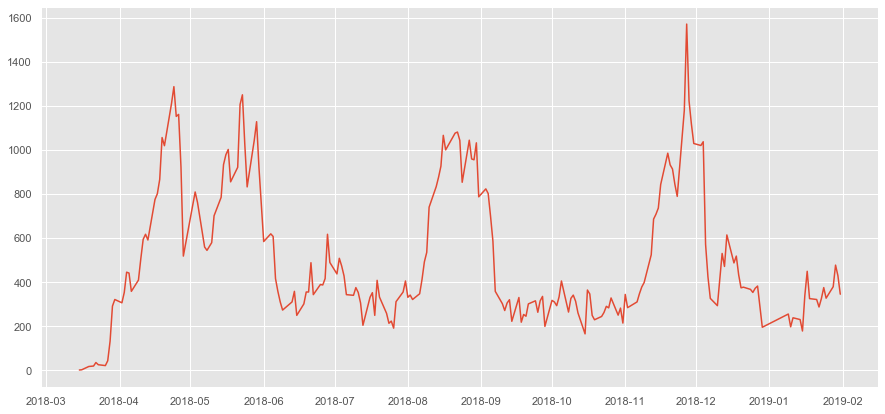

,date,manHours,dayofweek,month
0,2018-03-15,0.000000,3,3
1,2018-03-16,0.693147,4,3
2,2018-03-19,2.833213,0,3
3,2018-03-20,2.890372,1,3
4,2018-03-21,2.944439,2,3


In [4]:
df = pd.read_excel('~/Ts&Pr/project 2/data.xlsx')
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

plt.plot(df['date'],df['manHours'])
plt.show()

# данные достаточно волатильны, поэтому логарифмируем их
df['manHours'] = np.log(df['manHours'])


df.head()

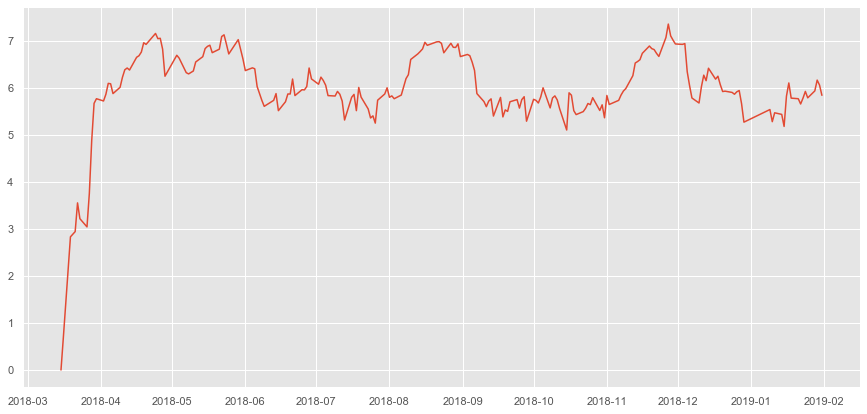

In [5]:
plt.plot(df['date'],df['manHours'])
plt.show()

manHours                    
               mean    median       std
dayofweek                              
0          5.984580  5.905362  0.882444
1          6.060797  6.012455  0.837577
2          6.055225  6.030685  0.728575
3          5.982962  6.030500  1.097658
4          5.896104  5.837730  1.028299
5          5.710816  5.609472  0.496310

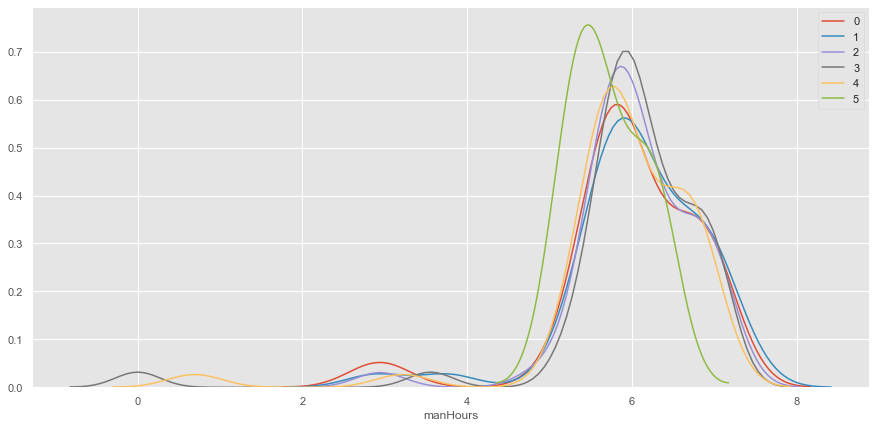

In [6]:
for i in range(6):
    sns.distplot(df[df['dayofweek']==i]['manHours'], hist=False, label=str(i))
    
df.groupby('dayofweek').agg({'manHours':['mean','median','std']})
# по субботам нагрузка значительно ниже
# остальные дни не показывают явных различий между собой

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


manHours                    
           mean    median       std
month                              
1      5.739714  5.783825  0.279430
3      3.272390  3.131699  1.726382
4      6.501192  6.424869  0.456126
5      6.752415  6.787738  0.239819
6      5.982383  5.919479  0.275011
7      5.782556  5.833338  0.276128
8      6.586445  6.775366  0.444907
9      5.825875  5.736442  0.421249
10     5.651878  5.669881  0.196923
11     6.530535  6.670766  0.510265
12     6.073717  6.023448  0.385564

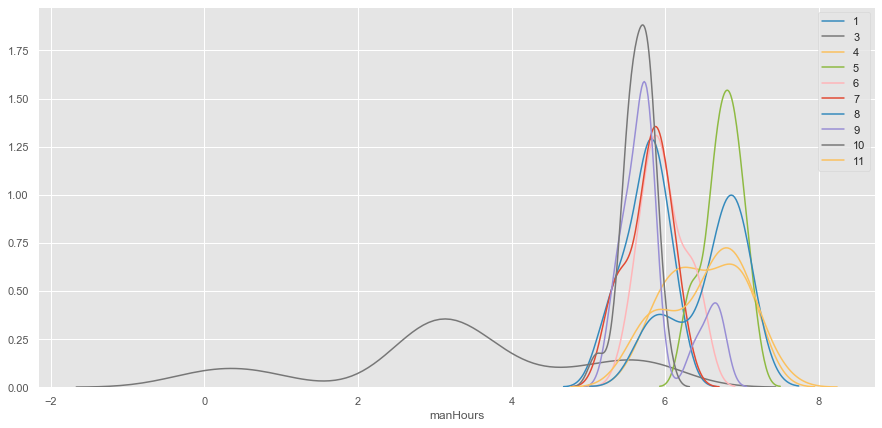

In [7]:
for i in range(12):
    sns.distplot(df[df['month']==i]['manHours'], hist=False, label=str(i))

df.groupby('month').agg({'manHours':['mean','median','std']})

# среди месяцев высокой нагрузкой выделяются апрель-май, авуст, ноябрь 
# на эти месяцы приходится середина квартала, и в них ожидается, вероятно, более высокая нагрузка

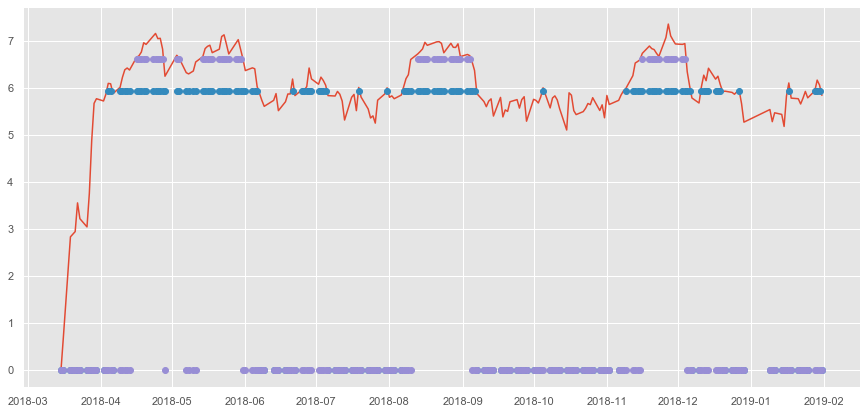

In [8]:
plt.plot(df['date'],df['manHours'])


c=np.quantile(df['manHours'],0.5)
plt.plot(df['date'],(df['manHours']>c)*c, 'o')
df['highLoad'] = (df['manHours']>c).astype(int)

c=np.quantile(df['manHours'],0.75)
plt.plot(df['date'],(df['manHours']>c)*c, 'o')
df['veryHighLoad'] = (df['manHours']>c).astype(int)
plt.show()

# если рассмотреть, где находятся наибольшие пики нагрузки, то они также приходятся на эти месяцы


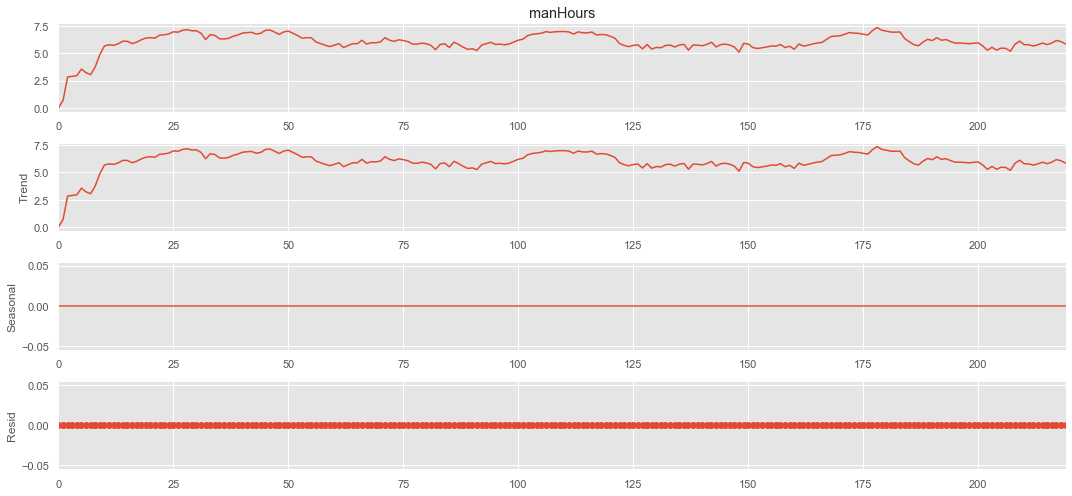

In [9]:
sm.tsa.seasonal_decompose(x=df['manHours'], period=1).plot()
plt.show()

# в данных нет явно сезонной компоненты

In [10]:
adfuller_test(df['manHours'], signif=0.05, name='manHours', verbose=False)
# ряд стационарный

    Augmented Dickey-Fuller Test on "manHours" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1665
 No. Lags Chosen       = 5
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0008. Rejecting Null Hypothesis.
 => Series is Stationary.


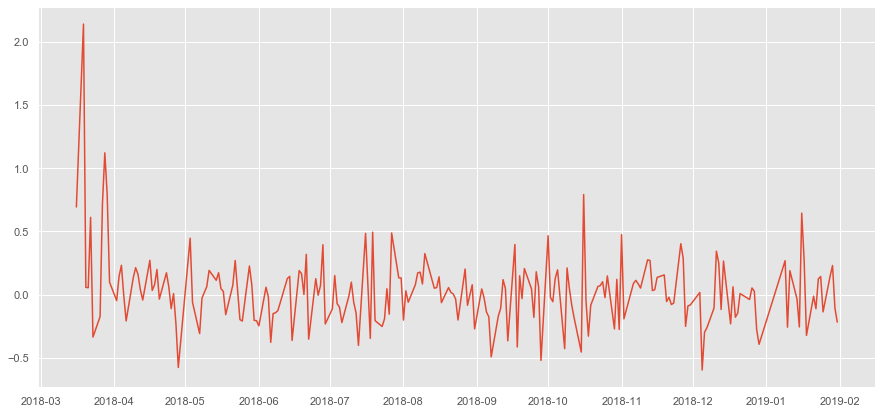

    Augmented Dickey-Fuller Test on "manHours first difference" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.6185
 No. Lags Chosen       = 0
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [11]:
plt.plot(df['date'],df['manHours'].diff())
plt.show()

adfuller_test(df['manHours'].diff().dropna(), signif=0.05, name='manHours first difference', verbose=False)

# после взятия первой разности ряд также стационарный

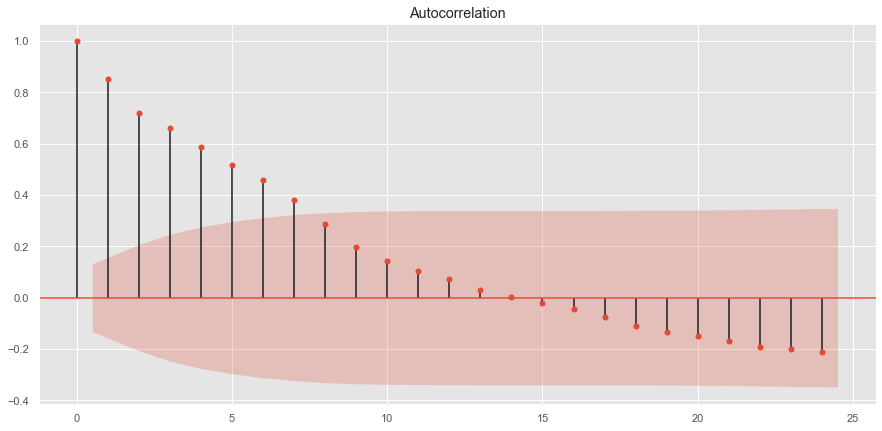

In [12]:
plot_acf(df['manHours'])
plt.show()

# несмотря на высокую автокорреляцию, изначальный ряд стационарный
# возможно стоит рассмотреть автокореляция ряда разностей



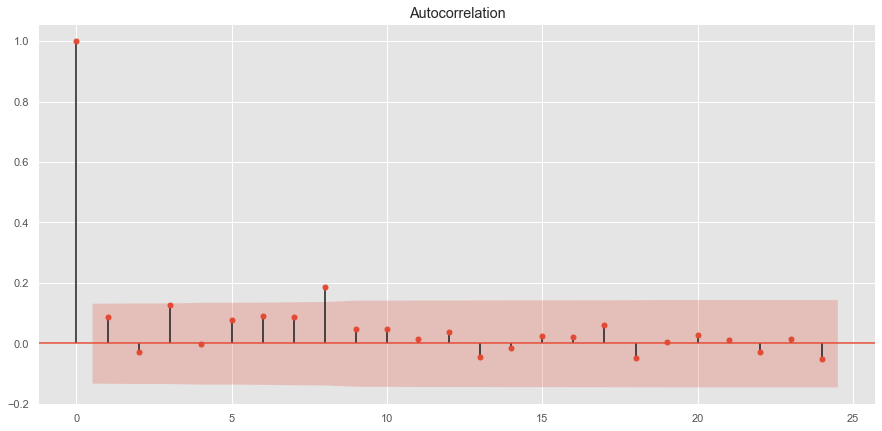

In [13]:
plot_acf(df['manHours'].diff().dropna())
plt.show()

# судя по графику автокорреляции дифференцированного ряда, стоит взять ряд разностей



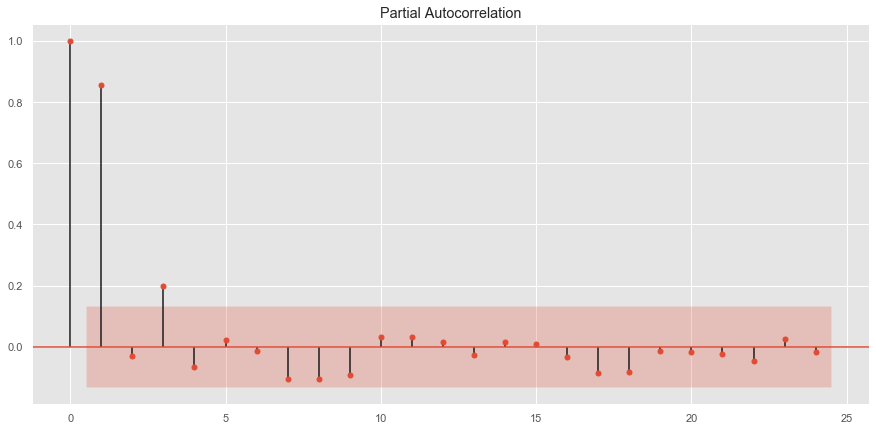

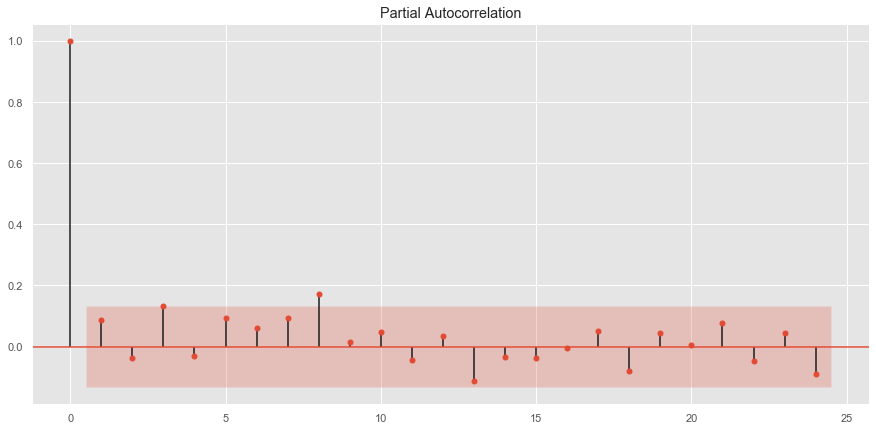

In [14]:
plot_pacf(df['manHours'])
plt.show()

# в случае изначального ряда стоит взять компоненту AR(2)

plot_pacf(df['manHours'].diff().dropna())
plt.show()

# в случае дифференцированного ряда стоит взять компоненту AR(1)

# провериим далее оба варианта

In [15]:
# ! pip install pmdarima
import pmdarima as pm

# SARIMAX Model
ex = pd.get_dummies(df[['dayofweek','month']].astype(str),drop_first=True) # дамми переменные на дни недели и месяцы
ex['highLoad'] = df['highLoad'] # дамми на высокие значения
ex['veryHighLoad'] = df['veryHighLoad'] # дамми на аномальные значения
ex['date'] = df['date']
ex = ex.set_index('date')

endog = df.set_index('date')['manHours']





In [16]:
# изначальный ряд
sxmodel_1 = pm.auto_arima(endog[10:], exogenous=ex[10:], 
                        # не будем исползовать первые 10 наблюдений при обучении, тк для них крайне низкие значения нагрузки
                        # эти данные похожи на выбросы
                           start_p=1, start_q=1,
                           max_p=14, max_q=14,
                           max_order=21, 
                           m=1, seasonal=False, D=None, 
                           d=0, stationary=True, test='adf',
                           with_intercept=True,
                           error_action='ignore', suppress_warnings=True, trace=True,
                           stepwise=True, random=True, maxiter=50, n_fits=15,
                           n_jobs=-1,
                       )

sxmodel_1.summary()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pmdarima/arima/auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-31.763, BIC=38.527, Time=0.661 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-114.942, BIC=-51.347, Time=0.557 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-21.149, BIC=45.793, Time=0.601 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-120.858, BIC=-53.916, Time=0.669 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=761.146, BIC=821.393, Time=0.117 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-116.776, BIC=-46.487, Time=0.756 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-36.515, BIC=37.122, Time=0.826 seconds
Total fit time: 4.193 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  80.429
Date:                Mon, 24 Feb 2020   AIC                           -120.858
Time:                        02:58:42   BIC                            -53.916
Sample:                             0   HQIC                           -93.796
                                - 210                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        5.6226      0.054    104.935      0.000       5.518       5.728
dayofweek_1      0.0343      0.034      1.021      0.307      -0.032       0.100
dayofweek_2      0.0445      0.043      1.046      0.296      -0.039       0.128
dayofweek_3      0.0437      0.040      1.080      0.280      -0.036       0.123
dayofweek_4     -0.0122      0.037     -0.332      0.740      -0.084       0.060
dayofweek_5     -0.1938      0.092     -2.116      0.034      -0.373      -0.014
month_10        -0.0088      0.059     -0.148      0.882      -0.125       0.107
month_11         0.2661      0.078      3.398      0.001       0.113       0.420
month_12         0.1428      0.075      1.909      0.056      -0.004       0.289
month_3          0.0987      0.249      0.397      0.691      -0.388       0.586
month_4          0.2347      0.080      2.926      0.003       0.077       0.392
month_5          0.2540      0.083      3.062      0.002       0.091       0.417
month_6          0.1380      0.074      1.873      0.061      -0.006       0.282
month_7          0.0232      0.057      0.410      0.682      -0.088       0.134
month_8          0.2174      0.087      2.490      0.013       0.046       0.389
month_9          0.0361      0.061      0.592      0.554      -0.084       0.156
highLoad         0.4200      0.045      9.280      0.000       0.331       0.509
veryHighLoad     0.5751      0.045     12.840      0.000       0.487       0.663
ma.L1            0.2098      0.075      2.801      0.005       0.063       0.357
sigma2           0.0272      0.003      8.811      0.000       0.021       0.033
===================================================================================
Ljung-Box (Q):                       28.49   Jarque-Bera (JB):                 3.36
Prob(Q):                              0.91   Prob(JB):                         0.19
Heteroskedasticity (H):               1.29   Skew:                            -0.31
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# ряд разностей
sxmodel_2 = pm.auto_arima(endog[10:], exogenous=ex[10:], 
                        # не будем исползовать первые 10 наблюдений при обучении, тк для них крайне низкие значения нагрузки
                        # эти данные похожи на выбросы
                           start_p=1, start_q=1,
                           max_p=14, max_q=14,
                           max_order=21, 
                           m=1, seasonal=False, D=None, 
                           d=1, stationary=True, test='adf',
                           with_intercept=True,
                           error_action='ignore', suppress_warnings=True, trace=True,
                           stepwise=True, random=True, maxiter=50, n_fits=15,
                           n_jobs=-1,
                         )


sxmodel_2.summary()



Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pmdarima/arima/auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-31.763, BIC=38.527, Time=0.662 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-114.942, BIC=-51.347, Time=0.561 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-21.149, BIC=45.793, Time=0.612 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-120.858, BIC=-53.916, Time=0.666 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=761.146, BIC=821.393, Time=0.115 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-116.776, BIC=-46.487, Time=0.736 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-36.515, BIC=37.122, Time=0.805 seconds
Total fit time: 4.162 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  80.429
Date:                Mon, 24 Feb 2020   AIC                           -120.858
Time:                        02:58:46   BIC                            -53.916
Sample:                             0   HQIC                           -93.796
                                - 210                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        5.6226      0.054    104.935      0.000       5.518       5.728
dayofweek_1      0.0343      0.034      1.021      0.307      -0.032       0.100
dayofweek_2      0.0445      0.043      1.046      0.296      -0.039       0.128
dayofweek_3      0.0437      0.040      1.080      0.280      -0.036       0.123
dayofweek_4     -0.0122      0.037     -0.332      0.740      -0.084       0.060
dayofweek_5     -0.1938      0.092     -2.116      0.034      -0.373      -0.014
month_10        -0.0088      0.059     -0.148      0.882      -0.125       0.107
month_11         0.2661      0.078      3.398      0.001       0.113       0.420
month_12         0.1428      0.075      1.909      0.056      -0.004       0.289
month_3          0.0987      0.249      0.397      0.691      -0.388       0.586
month_4          0.2347      0.080      2.926      0.003       0.077       0.392
month_5          0.2540      0.083      3.062      0.002       0.091       0.417
month_6          0.1380      0.074      1.873      0.061      -0.006       0.282
month_7          0.0232      0.057      0.410      0.682      -0.088       0.134
month_8          0.2174      0.087      2.490      0.013       0.046       0.389
month_9          0.0361      0.061      0.592      0.554      -0.084       0.156
highLoad         0.4200      0.045      9.280      0.000       0.331       0.509
veryHighLoad     0.5751      0.045     12.840      0.000       0.487       0.663
ma.L1            0.2098      0.075      2.801      0.005       0.063       0.357
sigma2           0.0272      0.003      8.811      0.000       0.021       0.033
===================================================================================
Ljung-Box (Q):                       28.49   Jarque-Bera (JB):                 3.36
Prob(Q):                              0.91   Prob(JB):                         0.19
Heteroskedasticity (H):               1.29   Skew:                            -0.31
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


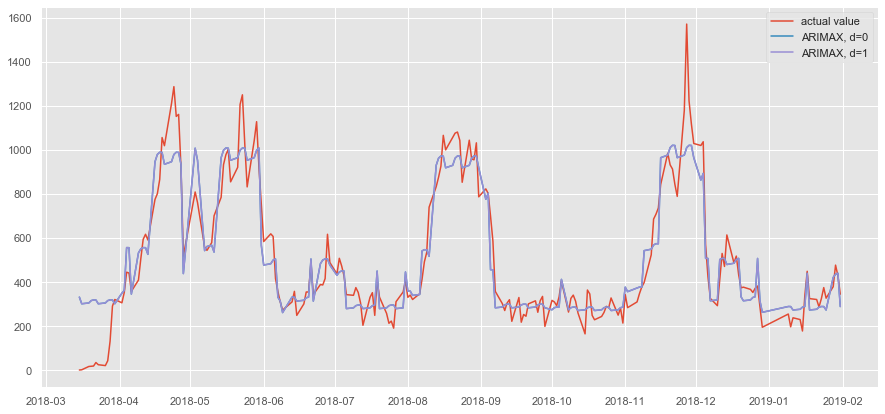

In [18]:
y_predict_log = sxmodel_1.predict(exogenous=ex,n_periods=len(ex))

plt.plot(df['date'],np.exp(df['manHours']),label='actual value')
plt.plot(df['date'],np.exp(y_predict_log),label='ARIMAX, d=0')

y_predict_log = sxmodel_2.predict(exogenous=ex,n_periods=len(ex))
plt.plot(df['date'],np.exp(y_predict_log),label='ARIMAX, d=1')
plt.legend()

plt.show()

# явной разницы между моделями нет!

Будем считать дополнительные издержки 

- если мы ожидаем высокой нагрузки и привлекаем сотрудников с высокой квалификацией, а нагрузка оказалась низкой, то мы переплачиваем дополнительно 2 у.е.
- если мы ожидаем низкой нагрузки и привлекаем сотрудников со средней квалификацией, а нагрузка оказалась высокой, то мы теряем дополнительно 1 у.е., так как могли бы нанять сотрудников с низкой квалификацией


$$ LostMoneyHours =  \sum_{t=0}^{T} \begin{cases}
    2 ( y_t - \hat{y}_t) & \text{if $ \hat{y}_t \leq y_t $} \\
    \hat{y}_t - y_t  & \text{if $ \hat{y}_t > y_t$}
  \end{cases}, $$


In [19]:
def metric_idx(y_pred, y_test):
    assert y_pred.shape == y_test.shape
    diff = y_pred - y_test
    return np.where(diff>0, diff, -2*diff)

def metric(y_pred, y_test):
    return metric_idx(y_pred, y_test).sum()


y_true = np.exp(df['manHours'].values)


y_predict_log = sxmodel_1.predict(exogenous=ex,n_periods=len(ex))
y_predict_1 = np.exp(y_predict_log)

y_predict_log = sxmodel_2.predict(exogenous=ex,n_periods=len(ex))
y_predict_2 = np.exp(y_predict_log)

metric(y_predict_1, y_true), metric(y_predict_2, y_true)

# с точки зрения выбора бизнесс-метрика также нет явных различий

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


(26191.186524104058, 26191.186524104058)

In [20]:
# попробуем оставить только значимые экзогенные переменные
ex_ = [
    'dayofweek_5', 
    'month_11', 'month_12', 'month_4', 'month_5', 'month_6', 'month_8', 
    'highLoad', 'veryHighLoad']

In [21]:
sxmodel_3 = pm.auto_arima(endog[10:], exogenous=ex[10:][ex_], 
                        # не будем исползовать первые 10 наблюдений при обучении, тк для них крайне низкие значения нагрузки
                        # эти данные похожи на выбросы
                           start_p=1, start_q=1,
                           max_p=14, max_q=14,
                           max_order=21, 
                           m=1, seasonal=False, D=None, 
                           d=0, stationary=True, test='adf',
                           with_intercept=True,
                           error_action='ignore', suppress_warnings=True, trace=True,
                           stepwise=True, random=True, maxiter=50, n_fits=15,
                           n_jobs=-1,
                       )

sxmodel_3.summary()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pmdarima/arima/auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-122.260, BIC=-78.748, Time=0.447 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-125.922, BIC=-89.104, Time=0.334 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-100.999, BIC=-60.834, Time=0.391 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-131.961, BIC=-91.796, Time=0.436 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1133.815, BIC=1167.286, Time=0.089 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-131.598, BIC=-88.086, Time=0.537 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-124.570, BIC=-77.711, Time=0.510 seconds
Total fit time: 2.750 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  77.981
Date:                Mon, 24 Feb 2020   AIC                           -131.961
Time:                        02:58:49   BIC                            -91.796
Sample:                             0   HQIC                          -115.724
                                - 210                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        5.6583      0.022    251.773      0.000       5.614       5.702
dayofweek_5     -0.2098      0.089     -2.346      0.019      -0.385      -0.035
month_11         0.2472      0.060      4.115      0.000       0.129       0.365
month_12         0.1230      0.062      1.983      0.047       0.001       0.245
month_4          0.2125      0.066      3.214      0.001       0.083       0.342
month_5          0.2336      0.068      3.411      0.001       0.099       0.368
month_6          0.1162      0.059      1.983      0.047       0.001       0.231
month_8          0.1978      0.073      2.724      0.006       0.055       0.340
highLoad         0.4312      0.041     10.397      0.000       0.350       0.513
veryHighLoad     0.5701      0.043     13.346      0.000       0.486       0.654
ma.L1            0.2084      0.072      2.913      0.004       0.068       0.349
sigma2           0.0279      0.003      9.223      0.000       0.022       0.034
===================================================================================
Ljung-Box (Q):                       27.72   Jarque-Bera (JB):                 4.42
Prob(Q):                              0.93   Prob(JB):                         0.11
Heteroskedasticity (H):               1.28   Skew:                            -0.36
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
y_predict_log = sxmodel_3.predict(exogenous=ex[ex_],n_periods=len(ex))
y_predict_3 = np.exp(y_predict_log)

metric(y_predict_1, y_true), metric(y_predict_3, y_true)

# с точки зрения критерия информативности AIC удается выбрать более хорошую модель
# однако с точки зрения бизнесс метрики лучше оставить изначальную

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


(26191.186524104058, 26344.445551350873)

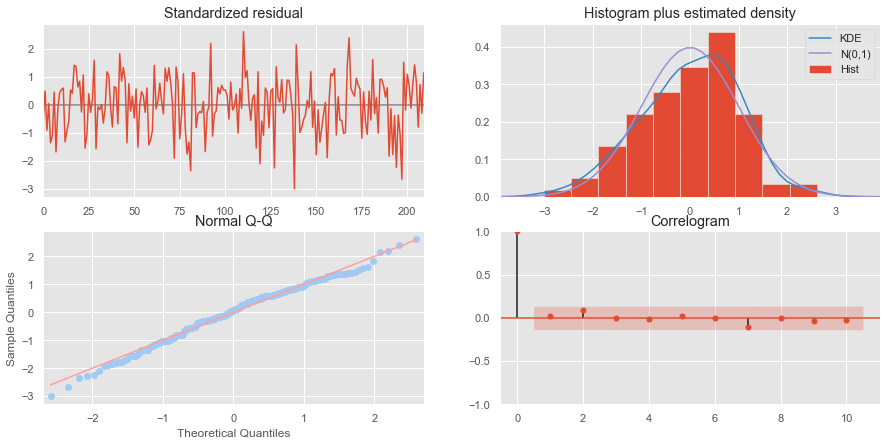

In [23]:
# проверим корректность нашей основной модели с пом. остатков
# станд. остатки распределены около нуля и равномерно
# остатки распределены почти нормально, хотя наблюдается некоторая ассиметрия
# автокорреляции в остатках нет

sxmodel_1.plot_diagnostics()
plt.show()

### Сравнение моделей

Для валидации моделей, связанных с предсказанием временных рядов, существует 2 классических подхода: метод скользящего окна и метод расширяющегося окна. При использовании скользящего окна для обучения модели используется фиксированный размер тестовой выборки, сдвигающийся по времени на размер окна. Метод расширяющегося окна на каждом шаге использует все больше тренировочных данных, но тестовое окно, аналогично предыдущему случаю, остаются фиксированным. Мы воспользуемся последним, так как он чаще применяется при небольших выборках согласно исследованию Убера, которое можно посмотреть $\href{https://eng.uber.com/forecasting-introduction/}{здесь.}$ Нас интересует как будет меняться значение метрики с увеличением окна, а также последнее и среднее значения. Мы задали 7 окон, т.к. на более маленькие подвыборки делить данные смысла нет, иначе тестовый набор не позволит хорошо оценить модели.

In [24]:
from sklearn.model_selection import TimeSeriesSplit

In [56]:
def fit_predict_loss(model, X, y):
    iter_ = 1
    losses = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_test = np.array([int(x) for x in y_test])
        y_train = np.array([int(x) for x in y_train])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        loss = metric(np.exp(y_pred), np.exp(y_test))
        losses.append(loss)
        iter_ += 1
    return losses

### Подходы, использующиеся в машинном обучении

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Начнем с простой линейной регрессии.

In [102]:
idf = df.set_index(['date'])

X = idf.values.astype('float32')[:, 1:]
y = idf.values.astype('float32')[:, :1]

tscv = TimeSeriesSplit(n_splits=7)

In [58]:
lr_model = LinearRegression()
lr_losses = fit_predict_loss(lr_model, X, y)

Text(0.5, 1.0, 'Linear Regression')

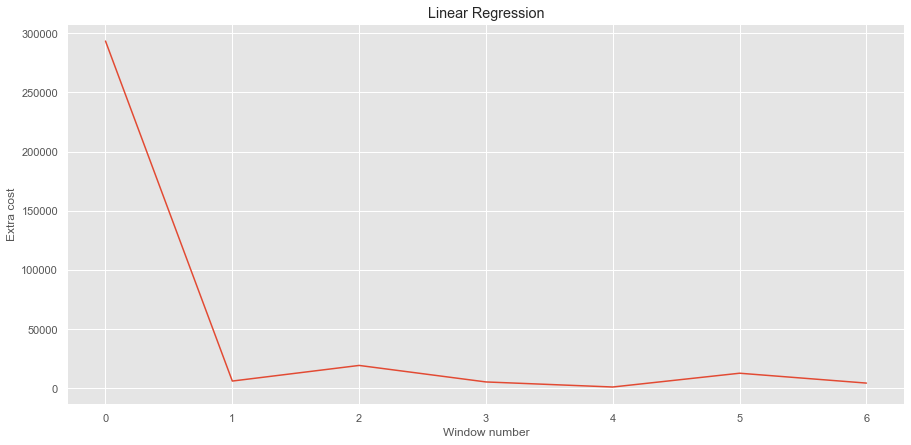

In [59]:
plt.plot(lr_losses)
plt.xlabel('Window number')
plt.ylabel('Extra cost')
plt.title('Linear Regression')

In [60]:
lr_losses[-1] # последнее значение предложенной метрики

4494.6638359901335

In [61]:
np.mean(lr_losses) # среднее значение предложенной метрики

48991.118908450786

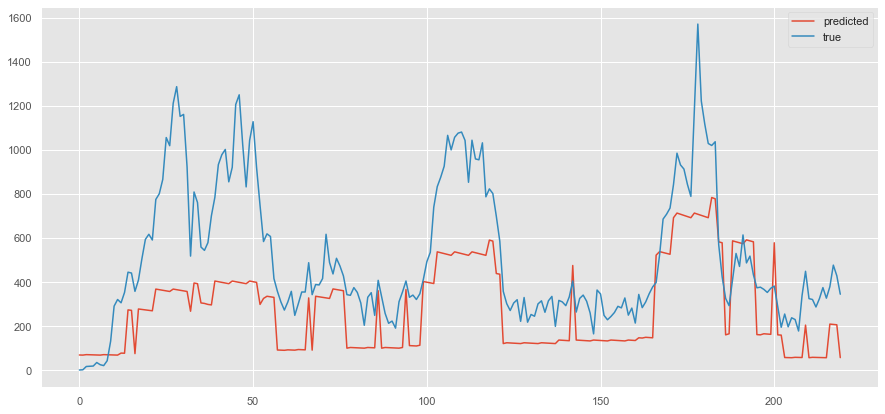

In [105]:
y_predicted = lr_model.predict(X)
y_predicted = np.exp(y_predicted)
yy = np.exp(y)
plt.plot(y_predicted, label='predicted')
plt.plot(yy, label='true')
plt.legend()

Теперь попробуем приметь метод случайного леса, обязательно настроив его параметры перед использованием. 

In [220]:
idf = df.set_index(['date'])

for i in range(28,30):
    idf['lag_'+str(i)] = idf['manHours'].shift(i) # добавим лаговые переменные

idf = idf.dropna()

X = idf.values.astype('float32')[:, 1:]
y = idf.values.astype('float32')[:, :1]

tscv = TimeSeriesSplit(n_splits=7)

In [221]:
rf = RandomForestRegressor(random_state = 42)
n_estimators = [4, 5, 7, 10, 15, 20, 30, 40, 50]
max_depth = [4, 5, 7, 10]
min_samples_split = [2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [222]:
def ParameterTuningRF(random_grid):
    import math
    prev_loss = [math.inf]
    for n_estim in random_grid['n_estimators']:
        for depth in random_grid['max_depth']:
            for min_samples in random_grid['min_samples_split']:
                
                rf_model = RandomForestRegressor(n_estimators=n_estim, min_samples_split=min_samples, 
                                                 max_depth=depth, random_state = 42)
                
                rf_losses = fit_predict_loss(rf_model, X, y)
                loss = np.mean(rf_losses)
                if loss <= min(prev_loss): 
                    params = [n_estim, depth, min_samples]
                prev_loss.append(loss)
    best_grid = {'n_estimators': params[0],
               'max_depth': params[1],
               'min_samples_split': params[2]}
    return best_grid

In [223]:
ParameterTuningRF(random_grid)

{'n_estimators': 40, 'max_depth': 4, 'min_samples_split': 2}

In [224]:
rf_model = RandomForestRegressor(n_estimators=40, min_samples_split=2, max_depth=4, random_state = 42)
rf_losses = fit_predict_loss(rf_model, X, y)

In [225]:
print('Feature importances')
for i in range(len(idf.columns[1:])):
    print(idf.columns[1:][i], ': ', rf_model.feature_importances_[i], sep='')

Feature importances
dayofweek: 0.005576207565342773
month: 0.00768353317736877
highLoad: 0.8879058133435743
veryHighLoad: 0.013606111627736719
lag_28: 0.05268793352524531
lag_29: 0.032540400760732176


Text(0.5, 1.0, 'Random Forest Regressor')

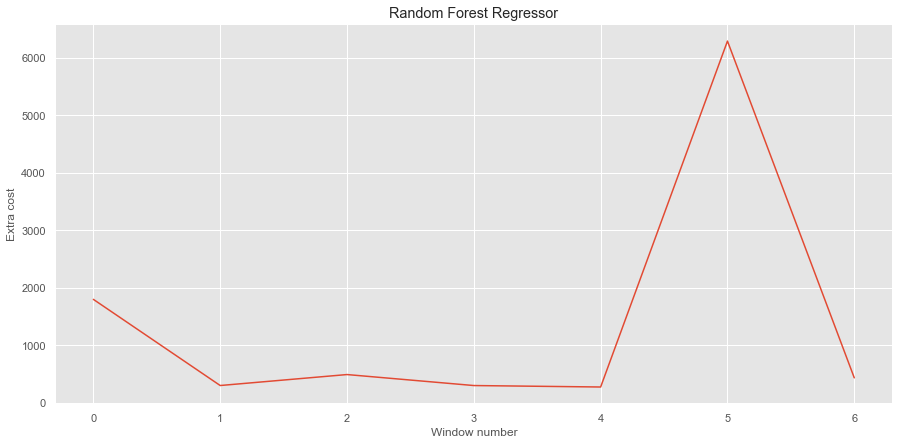

In [226]:
plt.plot(rf_losses)
plt.xlabel('Window number')
plt.ylabel('Extra cost')
plt.title('Random Forest Regressor')

In [227]:
rf_losses[-1] # последнее значение предложенной метрики

435.4700960409635

In [228]:
np.mean(rf_losses) # среднее значение предложенной метрики

1414.5493831032716

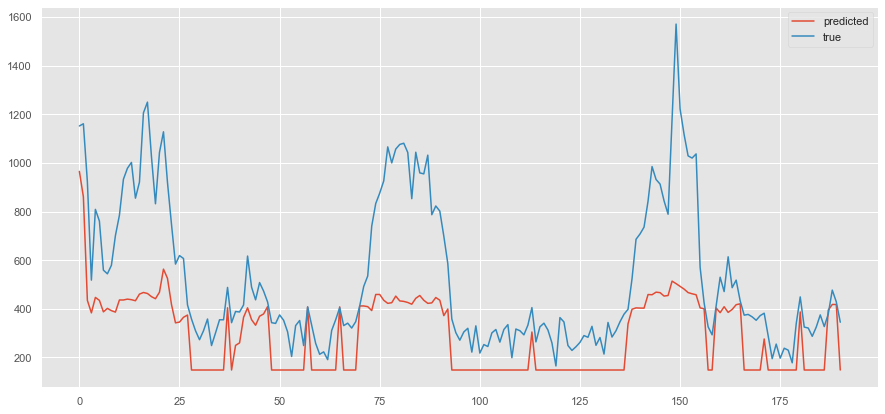

In [229]:
y_predicted = rf_model.predict(X)
y_predicted = np.exp(y_predicted)
yy = np.exp(y)
plt.plot(y_predicted, label='predicted')
plt.plot(yy, label='true')
plt.legend()

### Прогноз на февраль

In [246]:
ddf = df.copy()

for i in range(1, 29):
    new = ddf['date'][219] + datetime.timedelta(days=i)
    ddf = ddf.append({'date':new, 'highLoad':1, 'veryHighLoad':1}, ignore_index=True)

ddf['date'] = pd.to_datetime(ddf['date'])
ddf['dayofweek'] = ddf['date'].dt.dayofweek
ddf['month'] = ddf['date'].dt.month
#ddf = ddf.set_index(['date'])

for i in range(28,30):
    ddf['lag_'+str(i)] = ddf['manHours'].shift(i) # добавим лаговые переменные

In [247]:
X = ddf.iloc[:, 2:].dropna()[-28:]

In [248]:
rf_model.predict(X)

array([6.08261597, 6.09039375, 6.07136597, 6.14678797, 6.14678797,
       6.11901019, 6.07572251, 6.0623089 , 6.07136597, 6.04601965,
       6.08552418, 6.0617536 , 6.0827464 , 6.05487922, 6.0853374 ,
       6.0603374 , 6.0832675 , 6.1289346 , 6.09644165, 6.0758105 ,
       6.0472139 , 6.02816628, 6.05351261, 6.04601965, 6.1289346 ,
       6.15803797, 6.11901019, 6.07572251])

In [249]:
feb_pred = np.exp(rf_model.predict(X))

In [259]:
np.exp(df[['manHours', 'date']].set_index('date'))

,manHours
date,
2018-03-15,1.0
2018-03-16,2.0
2018-03-19,17.0
2018-03-20,18.0
2018-03-21,19.0
...,...
2019-01-25,327.0
2019-01-28,379.0
2019-01-29,477.0


In [272]:
fdf = df[['manHours', 'date']].set_index('date')
fdf = pd.DataFrame(np.exp(fdf))
fdf.head()

,manHours
date,
2018-03-15,1.0
2018-03-16,2.0
2018-03-19,17.0
2018-03-20,18.0
2018-03-21,19.0


In [269]:
d = {'date': ddf['date'][-28:], 'predictions': feb_pred}
feb_df = pd.DataFrame(data=d)
feb_df = feb_df.set_index('date')
feb_df.head()

,predictions
date,
2019-02-01,438.173949
2019-02-02,441.595256
2019-02-03,433.272116
2019-02-04,467.214268
2019-02-05,467.214268


In [270]:
feb_df.to_csv('~/Ts&Pr/project 2/feb_predictions.csv')

In [281]:
feb_df = feb_df.rename(columns={'predictions':'manHours'})
feb_df.head()

,manHours
date,
2019-02-01,438.173949
2019-02-02,441.595256
2019-02-03,433.272116
2019-02-04,467.214268
2019-02-05,467.214268


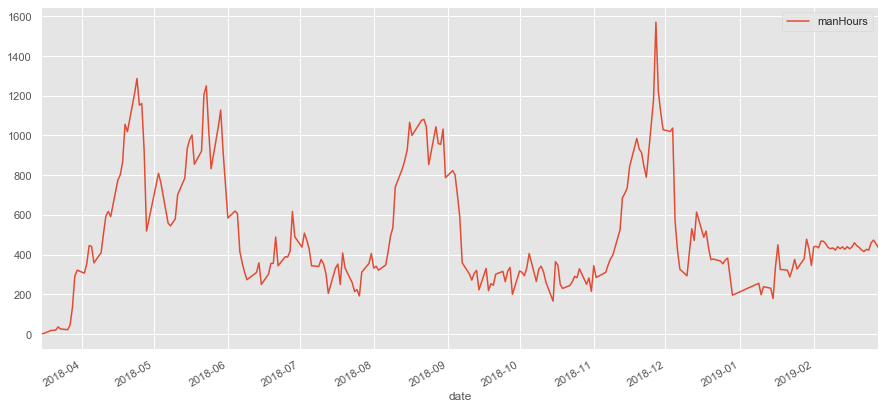

In [283]:
fdf.append(feb_df).plot()

#### Выбор наилучшей модели:

Судя по показателям метрик, бесспорно, наилучшей моделью будет случайный лес с подобранными выше параметрами.

#### Анализ предсказания на февраль:

В силу того, что слишком глубкие деревья или слишком большое количество деревьев на таком небольшом наборе данных могли легко привести к переобучению, наша модель не всегда оценивает масштаб выбросов полностью (предсказанные значения в пиковых точках ниже, чем на реальных данных), однако, практически все пиковые точки она находит. Это проиллюстрировано на графике с предсказаниями случайного леса. Поэтому можно предположить, что наша модель сможет выделить тренд.

#### Заключение:

В нашей работе был произведен анализ данного ряда на тренд, сезонность и стационарность, а также на выбросы и аномалии. Была выдвинута гипотеза о влиянии конца квартала на увеличение количества рабочих часов. Учитывая высокую важность (feature importance в разделе Случайный лес) признака, обозначающего месяц, можно предположить, что такое конец квартала действительно может влиять на количество человекочасов. Помимо этого была предложена бизнес-метрика, оценивающая количество переплаченных компанией денег из-за неправильного прогноза. Была подобрана схема валидации, произведены обучение и валидация моделей ARIMA, Линейная регрессия и Случайный лес. Где требуется, произведена настройка гиперпараметров. 